In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/improve-mie/examples/tutorials/analyzing_video_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Analyzing videos of a particle

In this tutorial, we will train a network to extract the intensity of a particle regardless of focus. The network will be trained to predict on videos of centered particles moving in and out of focus randomly.

## 1 Setup

Imports needed for this example.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2.1 Define the particle

We want to generate a video where the position of the particle changes over time. The x-y position of the particle will be roughly centered in each frame. This is to simulate a tracked particle centered by cropping a region of interest around it for each frame. The z position, however, will follow a Brownian motion with a random diffusion constant. 

To allow these properties to change in the video, we define two functions that return the value of these properties for each frame.

In [3]:
def get_position():
    v = 32 + np.random.randn(2) * 0.5
    return v

def get_z(previous_value, diffusion_constant, dt=1/30):
    return np.clip(previous_value + np.random.randn() * np.sqrt(diffusion_constant * dt) * 1e7, -60, 60)

## 2.2 Set initial values of the properties

The properties passed to create the instance of `Sphere` are used for the first frame of the video.

* `position` is initialized with the same function as that used for each subsequent frame.
* `z` is initialized as a normally distributed number centered around zero.
* `intensity` is constant 1. The intensity will be varied in a later step.
* `radius` is a random number between 200nm and 1000nm
* `position_unit` is set to pixels
* `upsample` is 4, increasing the resolution of the sphere.


In [4]:
particle_feature = dt.Sphere(
    position=get_position,
    z=lambda: np.random.randn() * 15,
    intensity=1,
    radius=lambda: 200e-9  + np.random.rand()*800e-9,
    diffusion_constant=lambda: (1 + np.random.rand() * 9) * 1e-12,
    position_unit="pixel",
    upsample=4
)

## 2.3 Make it sequential

To tell `particle_feature` how to change for each frame in a video, we call `Sequential` with the two functions defined in 2.1.

In [5]:
sequential_particle = dt.Sequential(particle_feature, z=get_z, position=get_position)

## 3.1 Define the full feature series

We define an optical device with some aberration. It is hard for the network to learn with heavy aberration. To mitigate this, the network will start training with very little aberration, and slowly increase the aberration as the network trains. 

To achieve this, we define a dummy property, `epoch`, which will return a number which increases by one each time the property is updated, up to `200`. The property `coefficient`, in turn, returns a normally distributed random number, with a standard deviation that scales with `epoch`. This way, the more times the property is updated, the more the optical device is aberrated.

In [6]:
epoch_cap = 200
get_coefficient = lambda epoch: np.random.randn() * 0.1 * epoch / epoch_cap

spherical_aberration = dt.SphericalAberration(
    epoch=iter(range(1, epoch_cap + 1)), 
    coefficient=get_coefficient
)

horizontal_coma = dt.HorizontalComa(
    epoch=iter(range(1, epoch_cap + 1)), 
    coefficient=get_coefficient
)

vertical_coma = dt.VerticalComa(
    epoch=iter(range(1, epoch_cap + 1)), 
    coefficient=get_coefficient
)

aberrations = spherical_aberration >> horizontal_coma >> vertical_coma

optics = dt.Fluorescence(
    NA=0.7,
    magnification=10,
    resolution=1e-6,
    wavelength=633e-9,
    output_region=(0, 0, 64, 64),
    pupil=aberrations
)

The on-camera captured intensity scales with the radius cubed times the property `intensity`. This means that the apparent intensity is much more dependent on the radius of the object than the intensity of each voxel. To remedy this, we define and apply a normalization feature to the `Sphere`. `normalize_sum` ensure that the sum of all pixels in the input is equal to `scale`. Thus, the apparent intensity will only depend on the property `intensity` of the sphere.

In [7]:
normalize_sum = dt.Lambda(
    lambda scale: (
        lambda image: image / np.sum(image) * scale
    ),
    scale=100
)

In [8]:
def propagate_sequential_data(X, **kwargs):
    for dep in X.recurse_dependencies():
        if isinstance(dep, dt.properties.SequentialProperty):
            for key, value in kwargs.items():
                if hasattr(dep, key):
                    getattr(dep, key).set_value(value)

## 3.2 Bring it together

We define the full feature series by imaging the sequential particle and the normalization feature with `optics`. `Sequence(imaged_article, sequence_length=10)`, in turn, creates a feature that resolves videos of length 10.  

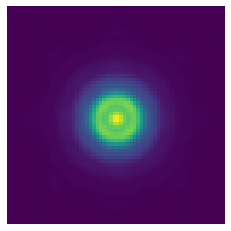

In [9]:
imaged_particle = optics(sequential_particle / dt.Sum(sequential_particle) * 100) 

imaged_particle_sequence = dt.Sequence(imaged_particle, sequence_length=10)  


imaged_particle_sequence.update()
imaged_particle_sequence.plot()

## 3.3 Vary the intensity

Varying the intensity of the particle is equivalent to scaling the output image. This allows us to define an augmentation that converts a video of a particle of any intensity to any other intensity.

We additionally define the method `update_properties`. This method is unique to the class `Augmentation`, and it lets us update the properties of the video in accordance with the augmentation used. Here, it updates all instances of the `intensity` property in the video by multiplying it by the `multiplier` property of the feature.

In [10]:
class AugmentIntensity(dt.Augmentation):
    def get(self, image, multiplier, **kwargs):
        return image * multiplier

## 3.4 Augment the videos

For augmentation we will use a 8-way mirroring augmentation, followed by the aforementioned intensity augmentation. Noise is added after the augmentation to further diversify the generated dataset.

In [11]:
# Augment by flipping

augmented_particle_sequence = dt.Reuse(imaged_particle_sequence, uses=8)
augmented_particle_sequence = augmented_particle_sequence >> dt.FlipUD() >> dt.FlipLR() >> dt.FlipDiagonal()

intensity_augment = AugmentIntensity( 
    multiplier=lambda: 1 + np.random.rand() * 9,
    updates_per_reload=2
)

# # Augment by scaling intensity
augmented_particle_sequence = augmented_particle_sequence >> intensity_augment

offset = dt.Add(value=lambda: np.random.rand() * 1)
augmented_particle_sequence >>= offset >> dt.Poisson(snr=40, background=offset.value)

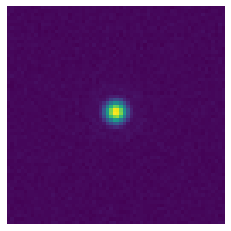

In [12]:
augmented_particle_sequence.update()
augmented_particle_sequence.plot()

## 4.1 Define the model

The model used will be `RNN`, which is a Recurrent Neural Network. The model acts like a convolutional neural network applied to each step of the video, followed by a LSTM layer, which merges all the information into a single output. RNNs can model complicated temporal behavours of videos of arbitrary length.

In [13]:
model = dt.models.RNN(input_shape=(None, 64, 64, 1), 
            rnn_layers_dimensions=(32, 32),
            dense_layers_dimensions=(32, 32),
            number_of_outputs=1, 
            loss="mse")


## 4.2 Define the label and the generator

The label function extracts the property `intensity` from the first frame of the video. The generator is a standard generator with `ndim` set to 5 to account for it resolving videos instead of images.

In [14]:
# Label function
particle_intensity = intensity_augment.multiplier

generator = dt.generators.ContinuousGenerator(
    augmented_particle_sequence & dt.Value(particle_intensity),
    batch_function=lambda x: x[:-1],
    label_function=lambda x: x[-1],
    batch_size=16,
    min_data_size=512,
    max_data_size=1024,
    ndim=5
)

## 5. Train the model

We train the model for 30 epochs, consisting of 100 batches eachs. This may take some time (a few minutes).

Note that some versions of Tensorflow do not correctly handle videos like these correctly. If you see an error such as `GPU sync failed` try updating Tensorflow.

Note that the model does not always train. If the model hasn't decreased past a loss of ~5 after 40 epochs, consider restarting (by creating a new model in cell 12)

In [15]:
with generator:
    model.fit(generator, epochs=200)

Generating 518 / 512 samples before starting training
Epoch 1/200
32/32 [==============================] - 7s 12ms/step - loss: 23.7845
Epoch 2/200
32/32 [==============================] - 0s 11ms/step - loss: 6.3353
Epoch 3/200
32/32 [==============================] - 0s 12ms/step - loss: 6.9812
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 6.8220
Epoch 5/200
32/32 [==============================] - 0s 11ms/step - loss: 7.1098
Epoch 6/200
32/32 [==============================] - 0s 12ms/step - loss: 6.4785
Epoch 7/200
32/32 [==============================] - 0s 12ms/step - loss: 6.9561
Epoch 8/200
32/32 [==============================] - 0s 12ms/step - loss: 6.1842
Epoch 9/200
32/32 [==============================] - 0s 12ms/step - loss: 4.3460
Epoch 10/200
32/32 [==============================] - 0s 12ms/step - loss: 4.3942
Epoch 11/200
32/32 [==============================] - 0s 12ms/step - loss: 3.7379
Epoch 12/200
32/32 [==============================] 

## 6. Validate the model

We validate the correctness of the model by generating 200 videos and creating a scatter plot of predicted intensity vs. actual intensity.

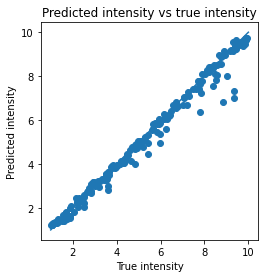

In [16]:
predicted_intensity = []
true_intensity = []
for _ in range(200):
    image = augmented_particle_sequence.update().resolve()
    label = particle_intensity()

    prediction = model.predict(np.array([image]))
    predicted_intensity.append(prediction[0])
    true_intensity.append(label)
        
plt.scatter(true_intensity, predicted_intensity)
plt.plot([1, 10], [1, 10])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Predicted intensity vs true intensity")
plt.xlabel("True intensity")
plt.ylabel("Predicted intensity")
plt.show()